# Keras grad-cam實作
<img src='notebook_footage/grad_cam.jpg' width='50%' style='float:left;'><br>
>We propose a technique for making Convolutional Neural Network (CNN)-based models more transparent by visualizing the regions of input that are "important" for predictions from these models - or visual explanations. Our approach, called Gradient-weighted Class Activation Mapping (Grad-CAM), uses the class-specific gradient information flowing into the final convolutional layer of a CNN to produce a coarse localization map of the important regions in the image. Grad-CAM is a strict generalization of the Class Activation Mapping. Unlike CAM, Grad-CAM requires no re-training and is broadly applicable to any CNN-based architectures. We also show how Grad-CAM may be combined with existing pixel-space visualizations to create a high-resolution class-discriminative visualization (Guided Grad-CAM). We generate Grad-CAM and Guided Grad-CAM visual explanations to better understand image classification, image captioning, and visual question answering (VQA) models. In the context of image classification models, our visualizations (a) lend insight into their failure modes showing that seemingly unreasonable predictions have reasonable explanations, and (b) outperform pixel-space gradient visualizations (Guided Backpropagation and Deconvolution) on the ILSVRC-15 weakly supervised localization task. For image captioning and VQA, our visualizations expose the somewhat surprising insight that common CNN + LSTM models can often be good at localizing discriminative input image regions despite not being trained on grounded image-text pairs. Finally, we design and conduct human studies to measure if Guided Grad-CAM explanations help users establish trust in the predictions made by deep networks. Interestingly, we show that Guided Grad-CAM helps untrained users successfully discern a "stronger" deep network from a "weaker" one even when both networks make identical predictions.

## grad-cam實作
本篇將介紹基於Keras的grad-csm實作，將使用Keras pre-trained model(weights:imagenet)作為預測模型，分別以vgg16以及resnet50為示範。

### Import dependencies

In [1]:
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### VGG16

In [2]:
#讀取vgg16模型
model = VGG16(weights='imagenet')

#### 讀取範例圖片

In [3]:
#grad-cam之示範圖片位置
img_path = 'image/elepnaht.jpg'

img = image.load_img(img_path, target_size=(224, 224))
rgb = cv2.imread(img_path)[:,:,::-1]
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

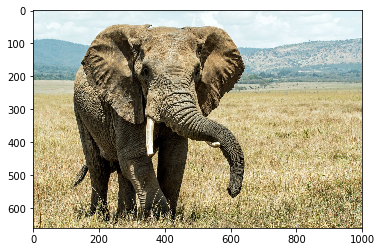

In [4]:
plt.imshow(rgb)
plt.show()

#### 模型對範例圖片之預測

In [5]:
preds = model.predict(x)
print(decode_predictions(preds))

[[('n02504458', 'African_elephant', 0.67008054), ('n01871265', 'tusker', 0.3088931), ('n02504013', 'Indian_elephant', 0.020647906), ('n02437312', 'Arabian_camel', 0.00019792312), ('n02099849', 'Chesapeake_Bay_retriever', 3.547182e-05)]]


### grad-cam實作

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [7]:
#模型預測示範圖片的類別為African_elephant機率最大
#以African_elephant的類別激勵程度作為本次示範
african_elephant_output = model.output[:,386] #African_elephant是第386類別
last_conv_layer = model.get_layer('block5_conv3') #取得模型中最後一層卷積層

In [8]:
#計算梯度
grad = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grad = K.mean(grad, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grad, last_conv_layer.output[0]])
pooled_grad_value, conv_layer_output_value = iterate([x])

In [9]:
for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grad_value[i]

#對卷積層產生之特徵圖做平均 (14,14,512) -> (14, 14, )
heatmap = np.mean(conv_layer_output_value, axis=-1)

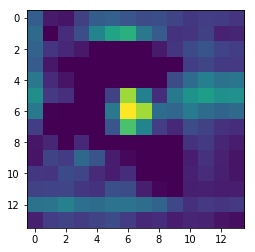

In [10]:
#類別激活狀況
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

plt.imshow(heatmap)
plt.show()

In [18]:
heatmap = cv2.resize(heatmap, (rgb.shape[1], rgb.shape[0]))
heatmap = np.uint8(heatmap*200)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)[:,:,::-1]
mix = cv2.addWeighted(rgb,0.6,heatmap,0.4,0)

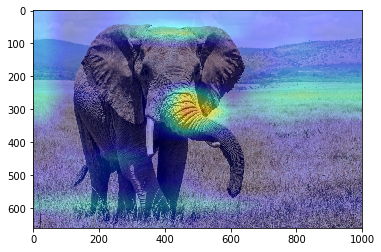

In [19]:
#類別激活圖與原圖跌加
plt.imshow(mix)
plt.show()

### RESNET50
以下將重複同樣的CODE，故不再註解

In [24]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [25]:
model = ResNet50(weights='imagenet')

In [26]:
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [27]:
preds = model.predict(x)
print(decode_predictions(preds))

[[('n02504458', 'African_elephant', 0.8270562), ('n01871265', 'tusker', 0.14899276), ('n02504013', 'Indian_elephant', 0.017266748), ('n02391049', 'zebra', 0.002042977), ('n02412080', 'ram', 0.0005709537)]]


In [28]:
african_elephant_output = model.output[:,386]
last_conv_layer = model.get_layer('res5c_branch2c')

In [29]:
grad = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grad = K.mean(grad, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grad, last_conv_layer.output[0]])
pooled_grad_value, conv_layer_output_value = iterate([x])

In [30]:
for i in range(2048):
    conv_layer_output_value[:,:,i] *= pooled_grad_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)

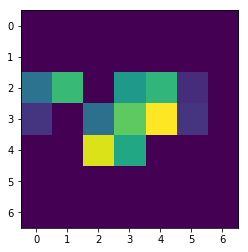

In [31]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

plt.imshow(heatmap)
plt.show()

In [32]:
img = cv2.imread(img_path)[:,:,::-1]
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(heatmap*200)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)[:,:,::-1]
mix = cv2.addWeighted(img,0.7,heatmap,0.3,0)

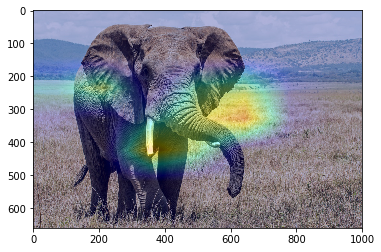

In [33]:
plt.imshow(mix)
plt.show()